In [292]:
# Para mas información, consulta el GitHub [https://github.com/Zygmut/Practica_3_IA]
# Autores: Palmer Pérez, Rubén; Torres Torres, Marc; Orr, Kieran Donal

# Setup
Importamos todos los paquetes necesarios para la práctica. 

In [293]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier 

Creamos un conjunto de variables para facil acceso y cambio de parámetros

In [294]:
TEST_SIZE = 0.33
CORRELATION_THRESHOLD = 0.05

Definimos una variable `DEBUG` (y su método de uso) que, en caso de estar activada, nos dará información adicional a lo largo de la ejecución del proyecto 

In [295]:
DEBUG = False 

def debugPrint(string):
    if DEBUG : print(string)

# El dataset
Cargamos los datasets y les añadimos la columna `type` que nos permitara reconocer de que tipo son una vez juntados los datasets. Si `type = 0` el vino será blanco, de lo contrario sera rojo   

In [296]:
white = pd.read_csv("dataset/winequality-white.csv", sep = ';')
white.insert(0, 'type', 0)
red = pd.read_csv("dataset/winequality-red.csv", sep= ';')
red.insert(0, 'type', 1)
df = pd.concat([white, red])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


Preparamos los datos del dataset eliminando todos los posibles valores nulos y transformando los valores que no sean `np.float64` o `np.int64` 

In [297]:
# Preparacion del dataset

labelencoder = LabelEncoder()

if not df[df.isna().any(axis=1)].shape[0] == 0 :
    debugPrint("Valores nulos eliminados para el dataframe")
    
df.dropna(inplace=True) # Eliminacion de valores nullos

for column in df.columns: # Transformar posibles valores no numericos
    if not df[column].dtype in (np.float64, np.int64):
        df[column] = labelencoder.fit_transform(df[column])
        debugPrint(f"Los valores de {column} se han transformado a numericos")


Miraremos la matriz de correlación para ver si tenemos algunos parametros que no contribuyan a la calidad del vino

<AxesSubplot:>

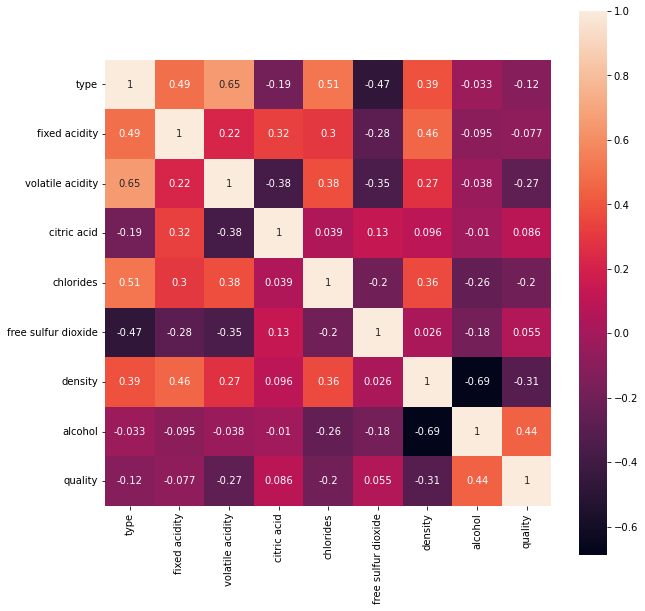

In [298]:
fig = plt.figure(figsize=(10,10))

removed_columns = []

for i in range(len(df.corr()["quality"])):
    if abs(df.corr()["quality"][i]) < CORRELATION_THRESHOLD:
        debugPrint(f"Removed column {i}") 
        removed_columns.append(i)
        

df.drop(df.columns[removed_columns], axis=1, inplace = True)
  
sns.heatmap(df.corr(), annot=True, square=True)


Adicionalmente, definiremos unos rangos de calidad de tal manera que :
- baja &rarr; "quality" < 6
- media &rarr; "quality" = 6
- alta &rarr; "quality" > 6

In [299]:
# TODO

### Separación del conjunto de entrenamiento, validación y testeo
Una vez obtenido nuestro dataset con sus valores procesados, creamos los 2 subconjuntos de datos que nos permitirán entrenar nuestros modelos (entrenamiento y testeo). El subconjutno de validación se creará posteriormente.

In [303]:
sc = StandardScaler()

y = df["quality"]
df.drop("quality", axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=TEST_SIZE, random_state=27)

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Modelos
Una vez preparado nuestros datasets de entrenamiento y testeo, podemos usarlos para nuestros modelos de machine learning

## Aplicación

### Regresión lineal

In [308]:
clr = LogisticRegression(random_state=0).fit(x_train, y_train)
y_hat = clr.predict(x_test)
targetNames = df["quality"].unique
print(targetNames)
#print(classification_report(y_test, y_hat, target_names=targetNames))

D:\Users\ruben\anaconda3\envs\ml-enviroment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyError: 'quality'

### Perceptron

In [10]:
cp = Perceptron(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)
print(classification_report(y_test, y_hat, target_names=["WHITE", "RED"]))

ValueError: Number of classes, 7, does not match size of target_names, 2. Try specifying the labels parameter

### Random forest

In [17]:
crf = RandomForestClassifier(random_state=0).fit(x_train, y_train)
y_hat = cp.predict(x_test)
print(classification_report(y_test, y_hat, target_names=["WHITE", "RED"]))

              precision    recall  f1-score   support

       WHITE       0.89      1.00      0.94      1614
         RED       1.00      0.63      0.77       531

    accuracy                           0.91      2145
   macro avg       0.94      0.81      0.86      2145
weighted avg       0.92      0.91      0.90      2145

